## Section 1
Sub-question: Are current solar and wind power plants in the country being predominantly built in areas of high solar and wind power potential?

1. Heatmap of Ph Regions according to Solar Potential per administrative boundary up to Barangay Level
2. Overlay the locations of wind and solar power plants in the country
3. Create histogram of # powerplants per band of wind potential per sqm

#### 1. Heatmap of Ph Regions according to Solar Potential per administrative boundary up to Barangay Level

Solar Potential

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import xlsxwriter
from shapely.geometry import Point, Polygon
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from math import sqrt

In [48]:

# taken from https://data.humdata.org/dataset/cod-ab-phl
fp = ".\Data\Shapefiles\Philippines\phl_admbnda_adm2_psa_namria_20200529.shp"
map_df = gpd.read_file(fp)
map_df.columns
map_df = map_df[['ADM2_EN', 'geometry']]


C:\Users\rayno\AppData\Local\Temp\ipykernel_27332\1795612701.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  powerplants = pd.read_csv(powerplantsfp)
C:\Users\rayno\AppData\Local\Temp\ipykernel_27332\1795612701.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  powerplants.capacity_mw = pd.to_numeric(powerplants.capacity_mw, errors='coerce')
c:\Program Files\Python310\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string =

<AxesSubplot:title={'center':'Solar Power Plants in the Philippines'}, ylabel='Average Specific Photovoltaic Power Output'>

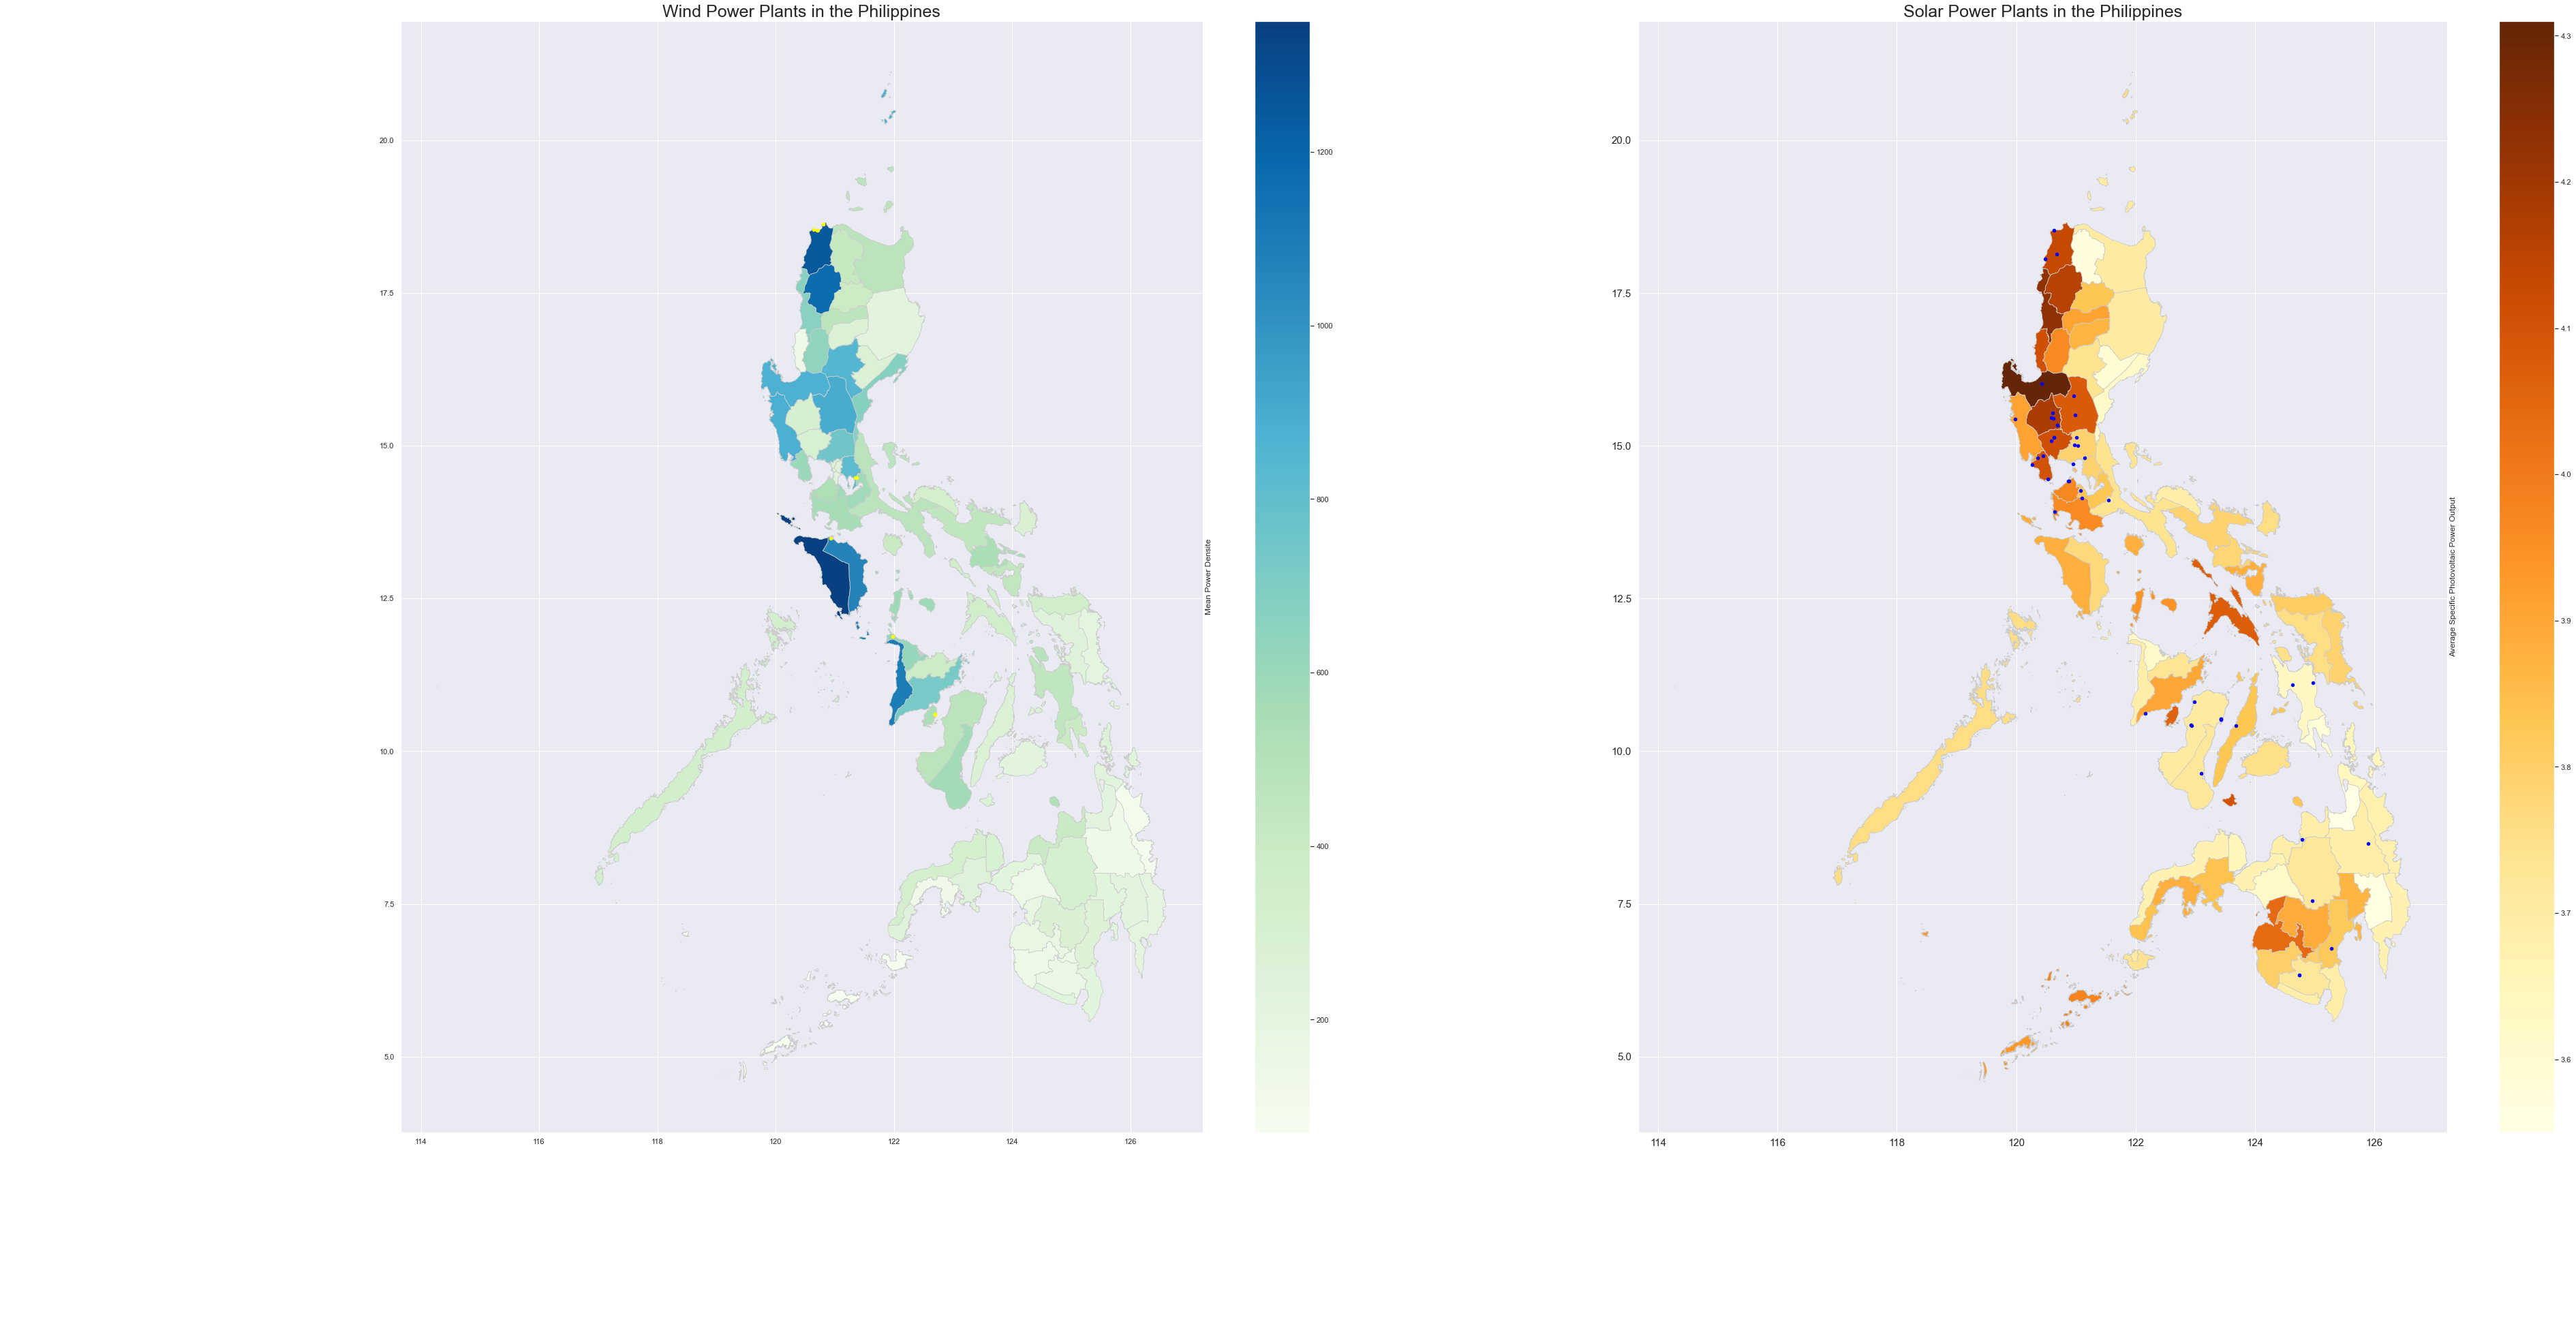

In [66]:
# PowerPlants
powerplantsfp = '.\Data\PowerPlants\global_power_plant_database.csv'
powerplants = pd.read_csv(powerplantsfp)
powerplants = powerplants[powerplants.country_long == 'Philippines']
powerplants.capacity_mw = pd.to_numeric(powerplants.capacity_mw, errors='coerce')

crs = {'init':'epsg:4326'}

solar_powerplants = powerplants[powerplants.primary_fuel == 'Solar']
solargeometry=[Point(xy) for xy in zip(solar_powerplants["longitude"], solar_powerplants["latitude"])]
geodata_solar=gpd.GeoDataFrame(solar_powerplants,crs=crs, geometry=solargeometry)

wind_powerplants = powerplants[powerplants.primary_fuel == 'Wind']
windgeometry=[Point(xy) for xy in zip(wind_powerplants["longitude"], wind_powerplants["latitude"])]
geodata_wind=gpd.GeoDataFrame(wind_powerplants,crs=crs, geometry=windgeometry)

# create figure and axes for Matplotlib
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(60, 30))

# Data for Wind Potential Heatmap
datafp = '.\Data\WindPotential\Philippine_regions_windpotential.csv'
wind_potential_data = gpd.read_file(datafp)
wind_potential_data = wind_potential_data[["ADM2_EN", "mean_power_density"]]
wind_potential_data.mean_power_density = pd.to_numeric(wind_potential_data.mean_power_density, errors='coerce')

merged_wind = map_df.set_index("ADM2_EN").join(wind_potential_data.set_index("ADM2_EN"))
variable_wind = "mean_power_density"

# Data for Solar Potential Heatmap
datafp = '.\Data\SolarPotential\Philippine_regions_pvpotential.csv'
solar_potential_data = gpd.read_file(datafp)
solar_potential_data = solar_potential_data[["ADM2_EN", "avg_specific_pv_output"]]
solar_potential_data.avg_specific_pv_output = pd.to_numeric(solar_potential_data.avg_specific_pv_output, errors='coerce')

merged_solar = map_df.set_index("ADM2_EN").join(solar_potential_data.set_index("ADM2_EN"))
variable_solar = "avg_specific_pv_output"

# Modifying Axes
#ax1.axis("off")
ax1.set_title("Wind Power Plants in the Philippines", fontdict = {"fontsize": "25", "fontweight":"3"})
#ax1.tick_params(labelsize=15)
ax1.figure.axes[1].tick_params(labelsize=15)
ax1.yaxis.set_label_position('right')
ax1.set_ylabel("Mean Power Densite")
ax1.annotate("Source: Global Wind Map, 2022",xy=(0, .0), xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize=12, color="#555555")

#ax2.axis("off")
ax2.set_title("Solar Power Plants in the Philippines", fontdict = {"fontsize": "25", "fontweight":"3"})
ax2.figure.axes[1].tick_params(labelsize=15)
ax2.yaxis.set_label_position('right')
ax2.set_ylabel("Average Specific Photovoltaic Power Output")
ax2.annotate("Source: Global Solar Map, 2022",xy=(0.4, .0), xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize=12, color="#555555")


# Plotting
merged_wind.plot(column=variable_wind, cmap="GnBu", linewidth=0.8, ax=ax1, edgecolor="0.8", legend=True)
geodata_wind.plot(ax=ax1, color='yellow', markersize=20)
merged_solar.plot(column=variable_solar, cmap="YlOrBr", linewidth=0.8, ax=ax2, edgecolor="0.8", legend=True)
geodata_solar.plot(ax=ax2, color='blue', markersize=20)


The above map shows the locations of solar and wind powerplants respectively, superimposed with a heatmap of the potential solar (average specific photovoltaic output) and wind (mean power density) power generation with a provincial resolution. Average Specific Photovoltaic Power output represents the amount of power generated per unit of the installed PV capacity over the long-term, and it is measured in kilowatthours per installed kilowatt-peak of the system capacity (kWh/kWp). Mean Power Density is the mean annual power available per square meter of swept area of a turbine, and is calculated for different heights above ground. Calculation of wind power density includes the effect of wind velocity and air density. 

C:\Users\rayno\AppData\Local\Temp\ipykernel_27332\4244513858.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geodata_solar[variable_solar][index] = merged_solar.loc[a.index.array[0]][variable_solar]
C:\Users\rayno\AppData\Local\Temp\ipykernel_27332\4244513858.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geodata_wind[variable_wind][index] = merged_wind.loc[a.index.array[0]][variable_wind]


Text(0.5, 0, 'Mean Power Density')

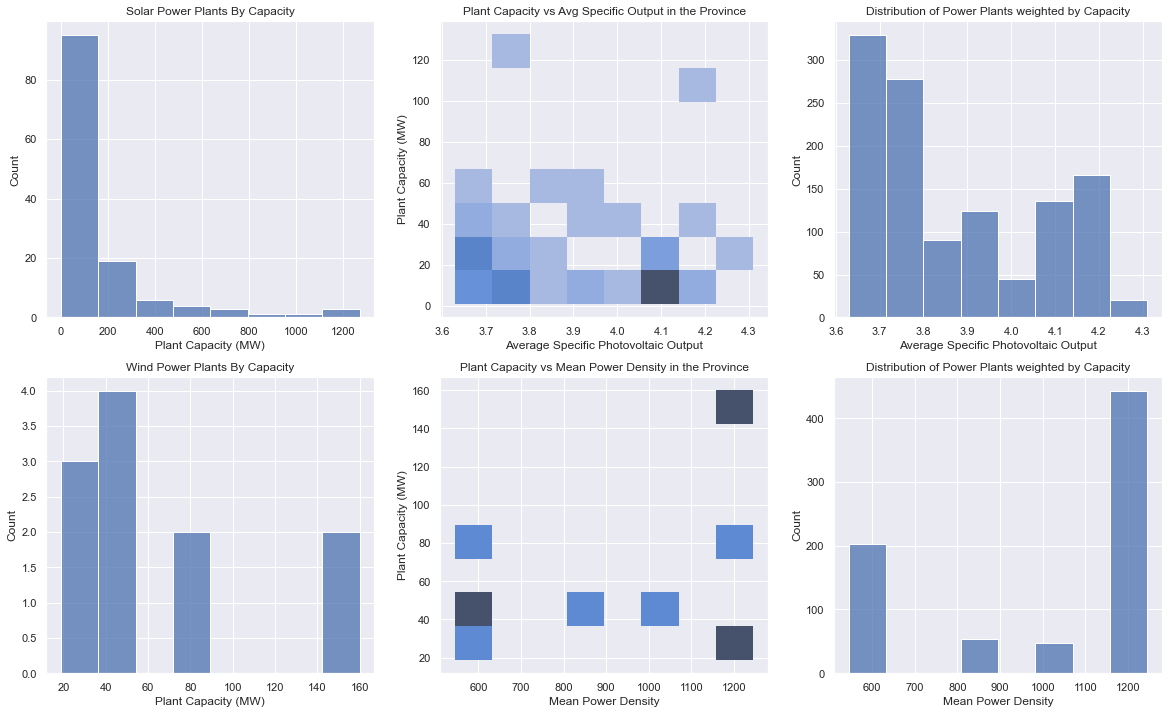

In [67]:
#Solar Powerplants analyses
geodata_solar[variable_solar] = None
for index, entry in geodata_solar.iterrows():
    a = merged_solar.geometry.contains(entry['geometry'])
    a = a[a == True]
    geodata_solar[variable_solar][index] = merged_solar.loc[a.index.array[0]][variable_solar]

fig, ((h1,h2,h3), (h4,h5,h6)) = plt.subplots(2,3, figsize=(20, 12))
sns.histplot(x='capacity_mw', data=powerplants, ax=h1,bins=8)
h1.set_title("Solar Power Plants By Capacity")
h1.set_xlabel("Plant Capacity (MW)")
sns.histplot(x=variable_solar, data=geodata_solar,y="capacity_mw",  bins=8, ax=h2)
h2.set_title("Plant Capacity vs Avg Specific Output in the Province")
h2.set_xlabel("Average Specific Photovoltaic Output")
h2.set_ylabel("Plant Capacity (MW)")
sns.histplot(x=variable_solar, data=geodata_solar, weights='capacity_mw', bins=8, ax=h3)
h3.set_title("Distribution of Power Plants weighted by Capacity")
h3.set_xlabel("Average Specific Photovoltaic Output")

#Wind Powerplants analyses
geodata_wind[variable_wind] = None
for index, entry in geodata_wind.iterrows():
    a = merged_wind.geometry.contains(entry['geometry'])
    a = a[a == True]
    geodata_wind[variable_wind][index] = merged_wind.loc[a.index.array[0]][variable_wind]

sns.histplot(x='capacity_mw', data=geodata_wind, ax=h4, bins=8)
h4.set_title("Wind Power Plants By Capacity")
h4.set_xlabel("Plant Capacity (MW)")
sns.histplot(x=variable_wind, data=geodata_wind, y="capacity_mw",  bins=8, ax=h5)
h5.set_title("Plant Capacity vs Mean Power Density in the Province")
h5.set_xlabel("Mean Power Density")
h5.set_ylabel("Plant Capacity (MW)")
sns.histplot(x=variable_wind,data=geodata_wind, weights='capacity_mw', bins=8, ax=h6)
h6.set_title("Distribution of Power Plants weighted by Capacity")
h6.set_xlabel("Mean Power Density")


The graphs "Solar Power Plants By Capacity" and "Wind Power Plans By Capacity" shows us a histogram of the currently operating wind and solar powerplants in the country. The distribution of "Solar Power Plants By Capacity" is heavily right-skewed, indicating that a majority of the solar powerplants in the country produce less than 200 MW per plant. This presents a missing gap in the solar power plant development in the country in that it might be beneficial to build larger-scale powerplants to take advantage of reduced prices stemming from mass procurement and production. 

The "Wind Power Plans By Capacity" graph also indicates a right-skewed distribution, leaning towards lower MW generation capacity per plant, with none generating more than 160 MW. This shows an opportunity that we could be building more wind powerplants with higher generation capacities to take advantage of the cost-reductions brought about by mass procurement and production.

The graphs in the center column of the above results are 2d histograms indicating the relationship between plant capacity and the solar or wind capacity of each region. The intersection of both signifies whether the wind/solar capacity of the province the plant is generated in and the MW capacity of the plant. As we can see on the graph for Solar Power Plants in the country, There is heavy investment in provinces with a solar potential of 4.1, with it being deeply highlighted, however a majority of these plants are low capacity (<20 MW). This indicates underinvestment in provinces with particularly high solar generation potential, and we must build more high capacity power plants in areas with more solat potential. Furthermore, there is also a concentration of investment in low-solar potential province with low-capacity power plants. This is perhaps a solution to intermittent electricity access in more remote areas of the country, although this indicates the need for a more robust and reliable power transmission network in the country



## Section 2

Sub-question: How much wind and solar energy is the Philippines projected to generate in the future? Can countries around the world be clustered based on solar and wind capacity, population, and GDP? If so, to which cluster does the Philippines belong, and has its cluster membership changed over time?

1. Take time-series data on [GDP, population, solar and wind capacity] per country. 
2. Perform KNN on the dataset from 1 per year, animate the result. Display in a 3D graph.
3. Highlight the Philippines performance and other notable countries in the KNN animation. Analysis.

4. Train a sequential NN on (gdp, population, cost of wind/solar power generation, cost of battery storage). 
5. Predict for coming 30 years based on projected gdp, solar/wind cost, population, and cost of battery storage)

6. Repeat 4 and 5 but on a RNN


#### KNN

In [51]:
years = ["2012","2013","2014","2015","2016","2017","2018","2019"]
years_num = [2012,2013,2014,2015,2016,2017,2018,2019]

Installedfp = '.\Data\InstalledCapacity\RECAP_20220519-053554.csv'
Installed = pd.read_csv(Installedfp, encoding = "ISO-8859-1")

Installed[years] = Installed[years].apply(pd.to_numeric, errors='coerce')
#Installed = Installed[Installed.Technology == "Solar"]

Popfp = '.\Data\PopAndGDP\Population.csv'
Pop = pd.read_csv(Popfp, encoding = "utf-8")
Pop[years] = Pop[years].apply(pd.to_numeric, errors='coerce')

GDPfp = '.\Data\PopAndGDP\GDPPerCapita.csv'
GDP = pd.read_csv(GDPfp, encoding = "utf-8")
GDP[years] = GDP[years].apply(pd.to_numeric, errors='coerce')



In [52]:
dfs = []
for year in years:
    df = pd.merge(Installed[["Country",year]], GDP[["Country",year]], on=["Country"], how='inner')
    df = pd.merge(df, Pop[["Country",year]], on=["Country"], how='inner')
    df = df.drop_duplicates()
    df.rename(columns={year+'_x':"Installed", year+'_y':"GDP", year:"Pop"}, inplace=True)
    df[["Installed", "GDP", "Pop"]] = df[["Installed", "GDP", "Pop"]].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(axis=0)
    df.Installed = df.Installed/df.Pop
    dfs.append(df)
    #print(year, df.shape)

Philippine Solar Power Capacity MW Installed per year

Explanation here

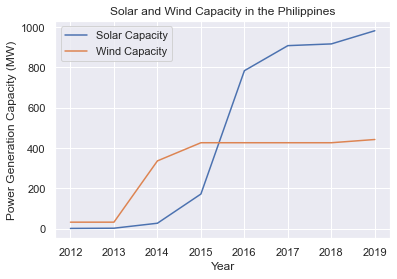

In [53]:
Installed_solar = Installed[Installed.Technology == "Solar"]
Installed_wind = Installed[Installed.Technology == "Wind"]


plt.plot(years,np.array(Installed_solar[Installed_solar["Country"] == "Philippines"][years].squeeze()), label="Solar Capacity")
plt.plot(years,np.array(Installed_wind[Installed_wind["Country"] == "Philippines"][years].squeeze()), label="Wind Capacity")
plt.title("Solar and Wind Capacity in the Philippines")
plt.xlabel("Year")
plt.ylabel("Power Generation Capacity (MW)")
plt.legend(loc='best')



C:\Users\rayno\AppData\Local\Temp\ipykernel_27332\2810083602.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_solar.drop(['Country', 'Technology'], axis=1, inplace=True)
C:\Users\rayno\AppData\Local\Temp\ipykernel_27332\2810083602.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind.drop(['Country', 'Technology'], axis=1, inplace=True)


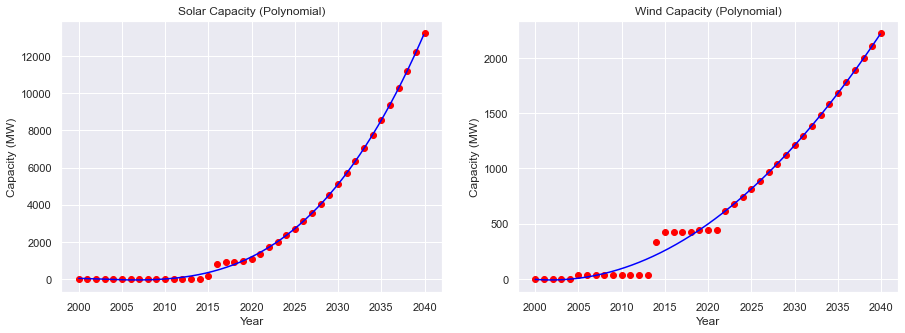

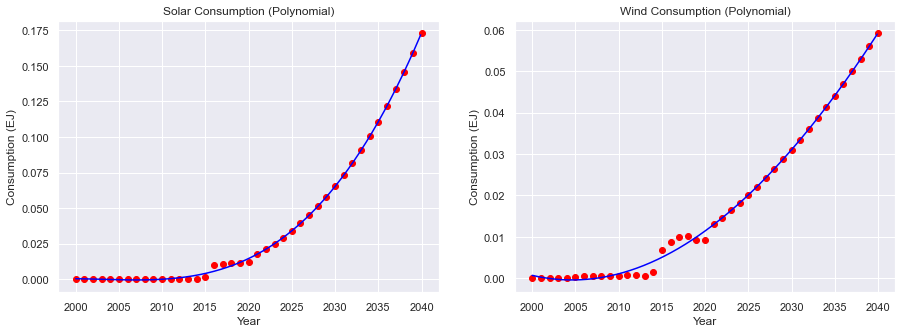

In [54]:
#import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the data into the dataframe for Capacity
df_capacity =  pd.read_csv('Data\InstalledCapacity\RECAP_20220519-053554.csv')
df_capacity = df_capacity.loc[df_capacity['Country'] == 'Philippines']
df_solar = df_capacity.loc[df_capacity['Technology'] == 'Solar']
df_wind = df_capacity.loc[df_capacity['Technology'] == 'Wind']

# Remove Country and Technology columns in place
df_solar.drop(['Country', 'Technology'], axis=1, inplace=True)
df_wind.drop(['Country', 'Technology'], axis=1, inplace=True)


# Take the capacity values
y_solar = df_solar.iloc[0].values
y_solar = y_solar.astype(float)
y_wind = df_wind.iloc[0].values
y_wind = y_wind.astype(float)

# Take the years
X_sw = df_solar.columns.values
X_sw = X_sw.astype(int)
X_sw = X_sw.reshape(-1, 1)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

poly_reg_solar = PolynomialFeatures(degree=4)
poly_reg_wind = PolynomialFeatures(degree=2)
X_poly_solar = poly_reg_solar.fit_transform(X_sw)
X_poly_wind = poly_reg_wind.fit_transform(X_sw)

lin_reg = LinearRegression()
lin_reg.fit(X_poly_solar,y_solar)

lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly_wind,y_wind)

# Making predictions for years 2022 till 2040
years = np.array([[i] for i in range(2022, 2041, 1)])
X_poly_solar = np.concatenate((X_sw,years))
X_poly_wind = np.concatenate((X_sw,years))

y_poly_solar = np.copy(y_solar)
y_poly_wind = np.copy(y_wind)
for i in range(2022, 2041, 1):
   y_poly_solar = np.concatenate((y_poly_solar,lin_reg.predict(poly_reg_solar.fit_transform([[i]]))))
   y_poly_wind = np.concatenate((y_poly_wind,lin_reg2.predict(poly_reg_wind.fit_transform([[i]]))))


X_grid_solar = np.arange(min(X_poly_solar),max(X_poly_solar),0.1)
X_grid_solar = X_grid_solar.reshape(len(X_grid_solar),1)
X_grid_wind = np.arange(min(X_poly_wind),max(X_poly_wind),0.1)
X_grid_wind = X_grid_wind.reshape(len(X_grid_wind),1) 

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_poly_solar,y_poly_solar, color='red') 
plt.plot(X_grid_solar, lin_reg.predict(poly_reg_solar.fit_transform(X_grid_solar)),color='blue') 
plt.title("Solar Capacity (Polynomial)")
plt.xlabel('Year')
plt.ylabel('Capacity (MW)')


plt.subplot(1, 2, 2)
plt.scatter(X_poly_wind,y_poly_wind, color='red') 
plt.plot(X_grid_wind, lin_reg2.predict(poly_reg_wind.fit_transform(X_grid_wind)),color='blue') 
plt.title("Wind Capacity (Polynomial)")
plt.xlabel('Year')
plt.ylabel('Capacity (MW)')

plt.show()

# Read the data into the dataframe for Consumption
df_consump_solar = pd.read_excel (r'Data\ConsumptionPercentage\bp-stats-review-2021-all-data.xlsx', sheet_name='Solar Consumption - EJ')
df_consump_wind = pd.read_excel (r'Data\ConsumptionPercentage\bp-stats-review-2021-all-data.xlsx', sheet_name='Wind Consumption - EJ')

df1_solar = df_consump_solar.iloc[99]
df1_wind = df_consump_wind.iloc[99]

# Check the consumption values for country Philippines
df1_solar = df_consump_solar.iloc[99,0:57]
df1_wind = df_consump_wind.iloc[99,0:57]

# Take the consumption values from excel sheet into string list
df1_solar_row = df_consump_solar.iloc[99,36:57].to_string(header=False, index=False)
df1_solar_row = df1_solar_row.split('\n')
df1_wind_row = df_consump_wind.iloc[99,36:57].to_string(header=False, index=False)
df1_wind_row = df1_wind_row.split('\n')


# Convert the list into dataframe
df1_solar_row = [float(_.strip()) for _ in df1_solar_row]
y1_solar = pd.DataFrame(df1_solar_row, columns=['Consumption'])
y1_solar = y1_solar.values

df1_wind_row = [float(_.strip()) for _ in df1_wind_row]
y1_wind = pd.DataFrame(df1_wind_row, columns=['Consumption'])
y1_wind = y1_wind.values

# Take the year values from excel sheet into string list
df1_solar_columns = df_consump_solar.iloc[1,36:58].to_string(header=False, index=False)
df1_solar_columns = df1_solar_columns.split('.0\n')
df1_wind_columns = df_consump_wind.iloc[1,36:58].to_string(header=False, index=False)
df1_wind_columns = df1_wind_columns.split('.0\n')

# Convert the list into dataframe
df1_solar_columns = [int(_.strip()) for _ in df1_solar_columns]
X1_solar = pd.DataFrame(df1_solar_columns, columns=['Years'])
X1_solar = X1_solar['Years'].unique()
X1_solar = X1_solar.reshape(-1,1)
df1_wind_columns = [int(_.strip()) for _ in df1_wind_columns]
X1_wind = pd.DataFrame(df1_wind_columns, columns=['Years'])
X1_wind = X1_wind['Years'].unique()
X1_wind = X1_wind.reshape(-1,1)

poly1_reg_solar = PolynomialFeatures(degree=3)
X1_poly_solar = poly1_reg_solar.fit_transform(X1_solar)
lin_reg3 = LinearRegression()
lin_reg3.fit(X1_poly_solar,y1_solar)
poly1_reg_wind = PolynomialFeatures(degree=4)
X1_poly_wind = poly1_reg_wind.fit_transform(X1_wind)
lin_reg4 = LinearRegression()
lin_reg4.fit(X1_poly_wind,y1_wind)

# Making predictions for years 2021 till 2040
years = np.array([[i] for i in range(2021, 2041, 1)])
X1_poly_solar = np.concatenate((X1_solar,years))
y1_poly_solar = np.copy(y1_solar)
X1_poly_wind = np.concatenate((X1_wind,years))
y1_poly_wind = np.copy(y1_wind)

for i in range(2021, 2041, 1):
   y1_poly_solar = np.concatenate((y1_poly_solar,lin_reg3.predict(poly1_reg_solar.fit_transform([[i]]))))
   y1_poly_wind =  np.concatenate((y1_poly_wind,lin_reg4.predict(poly1_reg_wind.fit_transform([[i]]))))

X1_grid_solar = np.arange(min(X1_poly_solar),max(X1_poly_solar),0.1)
X1_grid_solar = X1_grid_solar.reshape(len(X1_grid_solar),1) 
X1_grid_wind = np.arange(min(X1_poly_wind),max(X1_poly_wind),0.1)
X1_grid_wind = X1_grid_wind.reshape(len(X1_grid_wind),1) 

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(X1_poly_solar,y1_poly_solar, color='red') 
plt.plot(X1_grid_solar, lin_reg3.predict(poly1_reg_solar.fit_transform(X1_grid_solar)),color='blue') 
plt.title("Solar Consumption (Polynomial)")
plt.xlabel('Year')
plt.ylabel('Consumption (EJ)')

plt.subplot(1, 2, 2)
plt.scatter(X1_poly_wind,y1_poly_wind, color='red') 
plt.plot(X1_grid_wind, lin_reg4.predict(poly1_reg_wind.fit_transform(X1_grid_wind)),color='blue') 
plt.title("Wind Consumption (Polynomial)")
plt.xlabel('Year')
plt.ylabel('Consumption (EJ)')

plt.show()

The solar capacity of the Philippines has an upward trend projection similar to its corresponding consumption in the future if the Philippines could increase and maximize the potential of its solar power plants. The wind capacity of the Philippines has abrupt steady changes recorded in the past years similar to its corresponding consumption. If the Philippines manages to increase and maximize the potential of its wind power plants then the upward trend projection in capacity and consumption could be made possible.

World Solar Power Capacity MW Installed per year

Explanation here

Text(0.5, 1.0, 'Installed Solar Generation Capacities of Select Countries')

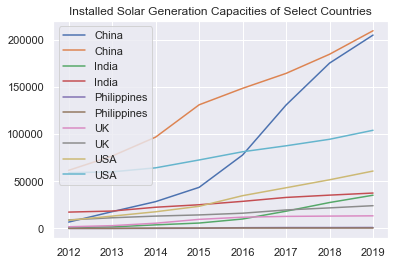

In [55]:
years = ["2012","2013","2014","2015","2016","2017","2018","2019"]
years_num = [2012,2013,2014,2015,2016,2017,2018,2019]

Installed[years] = Installed[years].apply(pd.to_numeric, errors='coerce')
for index,row in Installed.iterrows():
    if row["Country"] in ["Philippines", "China", "USA", "UK", "India"]:
        plt.plot(years, list(row[years]), label = row["Country"])

plt.legend(loc='best')
plt.title("Installed Solar Generation Capacities of Select Countries")

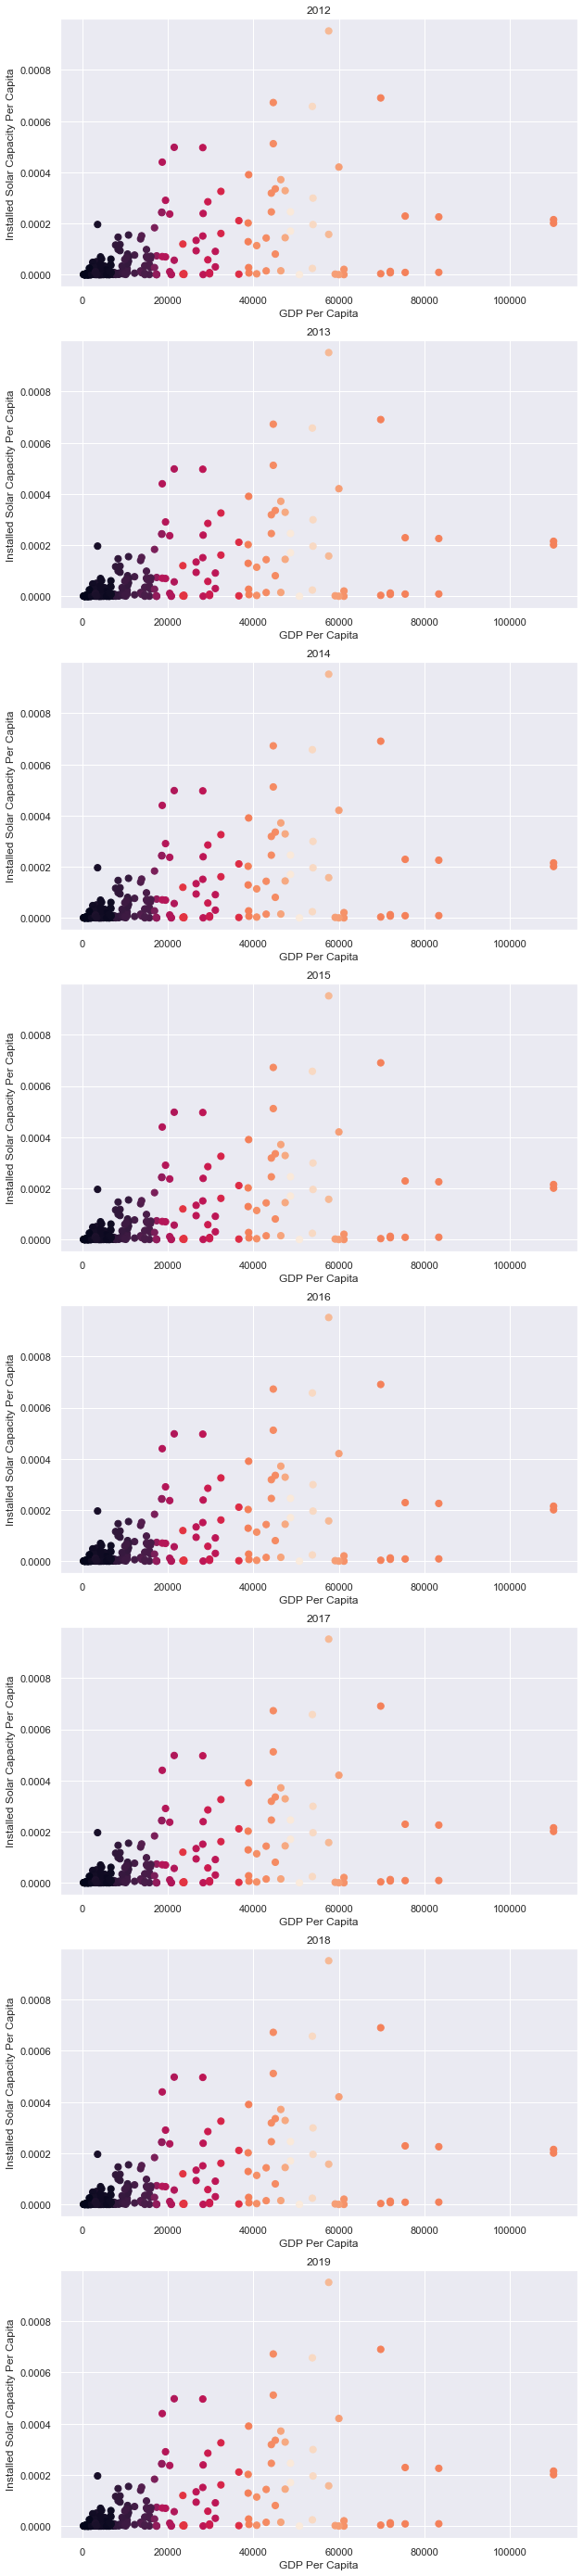

In [56]:
# 2D Plots with KNN
sns.set(style = "darkgrid")
fig, ax = plt.subplots(8,1,figsize=(10,50))
for i in range(len(years)):
    X = dfs[5][['GDP']]
    Y = dfs[5][['Installed']]

    parameters = {"n_neighbors": range(1,50)}
    gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
    gridsearch.fit(X, Y)

    train_preds_grid = gridsearch.predict(X)
    train_mse = mean_squared_error(Y, train_preds_grid)
    train_rmse = sqrt(train_mse)

    #cmap = sns.cubehelix_palette(as_cmap=True)
    points = ax[i].scatter(X, Y, c=train_preds_grid, s=50)#, cmap=cmap)

    #ax[i].scatter(dfs[i].GDP, dfs[i].Installed)
    #ax[i].scatter(dfs[i][dfs[i]["Country"] == "Philippines"].GDP, dfs[i][dfs[i]["Country"] == "Philippines"].Installed, color="red")
    ax[i].set_title(years[i])
    ax[i].set_xlabel("GDP Per Capita")
    ax[i].set_ylabel("Installed Solar Capacity Per Capita")

#fig.colorbar(points)